# CatBoost Drug Forecasting Model

This notebook implements a time series forecasting model using CatBoost to predict drug consumption patterns. The model leverages historical drug consumption data, calendar features, and lag/rolling window features to make multi-step predictions.



## Overview

- **Purpose**: Forecast future drug consumption for multiple drug categories
- **Model**: CatBoost Regressor with multi-output prediction
- **Features**: Calendar features, lag features, rolling statistics, and cross-drug correlations
- **Evaluation**: MAE, MSE, RMSE, MAPE, and R² metrics

In [59]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Configuration Parameters

Defining global parameters for the forecasting model:

- **Data Source**: Path to the CSV file containing time series data
- **Forecast Parameters**: Input window length, prediction horizon, and test/validation split ratios
- **Feature Engineering**: Lag periods and rolling window sizes for feature creation
- **Output**: Directory for saving results and visualization settings

In [60]:
# ---------------- CONFIG ----------------
CSV_PATH   = r"C:\Users\aravi\npn\catboost\daily_data.csv"
DATE_COL   = "datum"
PRED_LEN   = 2
INPUT_LEN  = 14
TEST_RATIO = 0.1
VAL_RATIO  = 0.1
OUTPUT_DIR = r"./catboost_outputs_final"
PLOT       = True
RANDOM_SEED = 42

DEFAULT_DRUGS = ["M01AB","M01AE","N02BA","N02BE","N05B","N05C","R03","R06"]
LAG_LIST      = [1,2,3,7,14]
ROLL_WINDOWS  = [3,7,14]

os.makedirs(OUTPUT_DIR, exist_ok=True)
np.random.seed(RANDOM_SEED)

### Calendar Feature Engineering

Adds date-based features to enhance the model's ability to capture seasonal patterns and trends.

In [61]:
# ---------------- UTILS ----------------
def add_calendar_features(df, date_col):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["dayofweek"] = df[date_col].dt.dayofweek
    df["weekofyear"] = df[date_col].dt.isocalendar().week
    df["quarter"] = df[date_col].dt.quarter
    df["is_month_start"] = df[date_col].dt.is_month_start.astype(int)
    df["is_month_end"] = df[date_col].dt.is_month_end.astype(int)
    return df

### Lag and Rolling Window Features

Creates time-lagged values and rolling statistics (mean, standard deviation) to capture temporal patterns and autocorrelations in the data.

In [62]:
def make_target_lag_features(df, target):
    df = df.copy()
    for L in LAG_LIST:
        df[f"{target}_lag{L}"] = pd.to_numeric(df[target].shift(L), errors='coerce').fillna(0.0)
    for W in ROLL_WINDOWS:
        df[f"{target}_rollmean{W}"] = pd.to_numeric(df[target].shift(1).rolling(W).mean(), errors='coerce').fillna(0.0)
        df[f"{target}_rollstd{W}"]  = pd.to_numeric(df[target].shift(1).rolling(W).std(), errors='coerce').fillna(0.0)
    return df


### Supervised Learning Table Creation

Transforms time series data into a supervised learning format with input windows and future target values for training machine learning models.

In [63]:
def build_supervised_table(df, target, input_len, pred_len, feature_cols):
    vals = df[target].astype(float).values
    feat_mat = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0).values
    X, y = [], []
    for t in range(input_len, len(df) - pred_len + 1):
        window = vals[t - input_len:t]
        feats = feat_mat[t - 1]
        future = vals[t:t + pred_len]
        X.append(np.hstack([window, feats]))
        y.append(future)
    return np.array(X), np.array(y)

  

### Model Evaluation Metrics

Calculates comprehensive performance metrics for regression models, including error measures and goodness-of-fit indicators.

In [64]:
def evaluate_all(y_true, y_pred):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    y_true_f_clip = np.clip(y_true_f, 1, None)
    mse = mean_squared_error(y_true_f, y_pred_f)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true_f, y_pred_f)
    mape = float(np.mean(np.abs((y_true_f - y_pred_f)/y_true_f_clip)) * 100)
    r2 = r2_score(y_true_f, y_pred_f)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}

### Time-Based Data Splitting

Splits data chronologically for training and testing, preserving the temporal order of observations.

In [65]:
def time_split(X, y, test_ratio):
    n = len(X)
    split_idx = max(1,int(n*(1-test_ratio)))
    return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]
   

### Validation Set Creation

Creates an inner validation set from the training data for model tuning and early stopping.

In [66]:
def inner_val_split(X_train, y_train, val_ratio):
    n = len(X_train)
    cut = max(1,int(n*(1-val_ratio)))
    return X_train[:cut], X_train[cut:], y_train[:cut], y_train[cut:]

### Forecast Visualization

Plots multi-step forecasts against actual values to visualize model performance across different prediction horizons.

In [67]:
def plot_horizons(y_test, y_pred, drug, out_dir=None, show_plot=True):
    steps = y_test.shape[1]
    fig, axes = plt.subplots(steps, 1, figsize=(10, 2.5*steps), sharex=True)
    if steps == 1: axes = [axes]
    for h in range(steps):
        axes[h].plot(np.expm1(y_test[:, h]), label=f"Actual t+{h+1}", marker="o")
        axes[h].plot(np.expm1(y_pred[:, h]), label=f"Pred t+{h+1}", linestyle="--", marker="x")
        axes[h].legend(); axes[h].grid(True)
    fig.suptitle(f"CatBoost Multi-step Forecast — {drug}")
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

    plot_path = None
    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)
        plot_path = os.path.join(out_dir, f"{drug}_forecast.png")
        plt.savefig(plot_path, dpi=150)

    if show_plot:
        plt.show()  # display plot in notebook

    plt.close(fig)
    return plot_path

## Model Training and Evaluation

### Drug-Specific Forecasting Function

This function handles the complete modeling pipeline for a specific drug category:

1. **Preprocess:** ensure drug cols → numeric, apply `log1p`.  
2. **Features:** date parts + lags `[1,2,3,7,14]` + rolling stats `[3,7,14]` + other drugs.  
3. **Dataset:** build supervised windows (`INPUT_LEN=14`, `PRED_LEN=2`).  
4. **Split:** time-based → train/val/test.  
5. **Model:** CatBoostRegressor (`iterations=1000`, `depth=6`, `lr=0.03`, `loss=MultiRMSE`).  
6. **Eval:** predict test, compute metrics (MAE, RMSE, R²), compare actual vs pred, plot if enabled.

In [68]:
# ---------------- TRAIN ----------------
def run_for_drug(df_all, drug_col):
    df = df_all.copy()
    
    # ------------------ Ensure all drugs numeric ------------------
    for c in DEFAULT_DRUGS:
        if c not in df.columns:
            df[c] = 0  # fill missing drug columns
        else:
            # convert to numeric, replace invalid with 0
            df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
        # log-transform
        df[c] = np.log1p(df[c])
    
    # ------------------ Make lag/roll features ------------------
    df = make_target_lag_features(df, drug_col)
    
    feature_cols = ["year","month","day","dayofweek","weekofyear","quarter","is_month_start","is_month_end"]
    for L in LAG_LIST:
        feature_cols.append(f"{drug_col}_lag{L}")
    for W in ROLL_WINDOWS:
        feature_cols.append(f"{drug_col}_rollmean{W}")
        feature_cols.append(f"{drug_col}_rollstd{W}")
    for c in DEFAULT_DRUGS:
        if c != drug_col:
            feature_cols.append(c)
    
    # ------------------ Prepare model dataframe ------------------
    df_model = df[[drug_col] + feature_cols].copy()
    # ensure numeric
    df_model = df_model.apply(pd.to_numeric, errors='coerce')
    df_model = df_model.fillna(0)  # fill NaNs instead of dropping rows
    
    # check if enough rows
    if len(df_model) < INPUT_LEN + PRED_LEN + 20:
        return {"drug": drug_col, "error": "Not enough rows"}
    
    # ------------------ Build supervised table ------------------
    X, y = build_supervised_table(df_model, drug_col, INPUT_LEN, PRED_LEN, feature_cols)
    if len(X) < 50:
        return {"drug": drug_col, "error": "Too few samples after windowing"}
    
    X_train, X_test, y_train, y_test = time_split(X, y, TEST_RATIO)
    X_tr, X_val, y_tr, y_val = inner_val_split(X_train, y_train, VAL_RATIO)
    
    # ------------------ Train model ------------------
    model = CatBoostRegressor(
        iterations=1000,
        depth=6,
        learning_rate=0.03,
        loss_function="MultiRMSE",
        thread_count=-1,
        random_seed=RANDOM_SEED,
        allow_writing_files=False,
        early_stopping_rounds=100
    )
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=100, use_best_model=True)
    
    # ------------------ Predict & evaluate ------------------
    y_pred = model.predict(X_test)
    metrics = evaluate_all(y_test, y_pred)
    
    # ------------------ Comparison table ------------------
    comp = pd.DataFrame({f"Actual_t+{h+1}": np.expm1(y_test[:, h]) for h in range(PRED_LEN)})
    for h in range(PRED_LEN):
        comp[f"Pred_t+{h+1}"] = np.expm1(y_pred[:, h])
    
    print(f"\n=== {drug_col} Prediction vs Actual ===")
    display(comp.head(10))
    
    if PLOT:
        plot_horizons(y_test, y_pred, drug_col)
    
    return {"drug": drug_col, **metrics}



## Main Execution

The main workflow processes each drug category in sequence:

1. Loads the dataset and adds calendar features
2. Iterates through each drug category
3. Applies the forecasting function to each drug
4. Collects and summarizes results across all drugs
5. Displays performance metrics and visualizations

Calendar features added: ['year', 'month', 'day', 'dayofweek', 'weekofyear', 'quarter', 'is_month_start', 'is_month_end']

===== Processing M01AB =====
0:	learn: 0.7299563	test: 0.7524768	best: 0.7524768 (0)	total: 74.6ms	remaining: 1m 14s
100:	learn: 0.6632734	test: 0.7419134	best: 0.7419134 (100)	total: 1.33s	remaining: 11.9s
200:	learn: 0.6186510	test: 0.7369621	best: 0.7366882 (191)	total: 2.56s	remaining: 10.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7366882304
bestIteration = 191

Shrink model to first 192 iterations.

=== M01AB Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,4.33,2.67,3.904542,3.529832
1,2.67,4.00,3.800585,4.379793
2,4.00,2.83,4.248872,4.422925
3,2.83,8.34,4.836958,4.362467
4,8.34,6.68,4.199004,4.973980
5,6.68,2.33,4.975053,4.754639
6,2.33,9.00,4.462169,4.145432
7,9.00,5.67,3.781516,3.831636
8,5.67,2.33,4.041708,4.120319
9,2.33,4.66,4.096677,4.507311


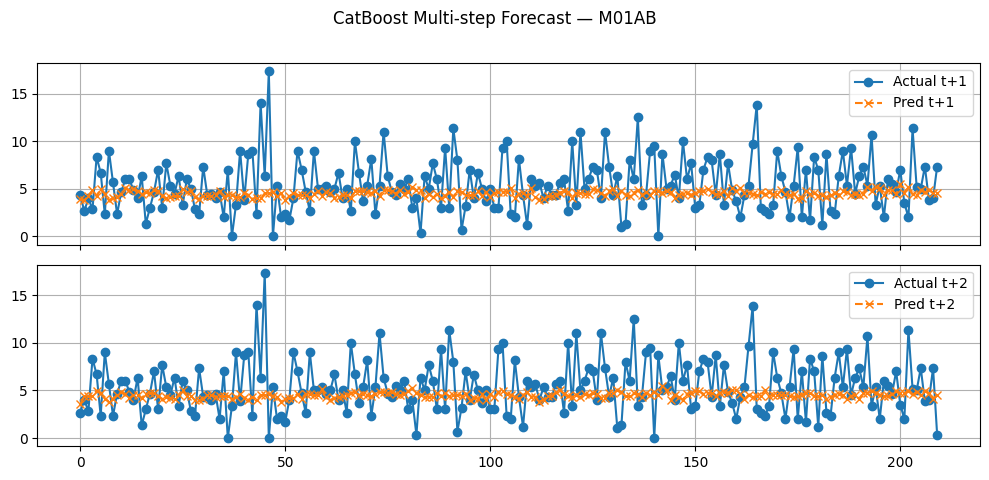

{'drug': 'M01AB', 'MAE': np.float64(0.3817783216470754), 'MSE': np.float64(0.24680417174248154), 'RMSE': 0.4967938926179362, 'MAPE': 24.181039559471763, 'R2': -0.0350079783146513}

===== Processing M01AE =====
0:	learn: 0.6689575	test: 0.7404427	best: 0.7404427 (0)	total: 18.4ms	remaining: 18.4s
100:	learn: 0.6170632	test: 0.7146584	best: 0.7144490 (95)	total: 1.64s	remaining: 14.6s
200:	learn: 0.5782624	test: 0.7085716	best: 0.7080156 (164)	total: 2.77s	remaining: 11s
300:	learn: 0.5442292	test: 0.7086229	best: 0.7071153 (252)	total: 3.87s	remaining: 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7071153188
bestIteration = 252

Shrink model to first 253 iterations.

=== M01AE Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,3.373,4.340,3.058009,3.191297
1,4.340,5.670,3.137657,3.221817
2,5.670,1.340,3.065372,3.356288
3,1.340,0.837,2.888681,3.233627
4,0.837,3.723,3.327648,3.153159
5,3.723,0.835,3.467843,3.432760
6,0.835,3.330,3.348564,3.049771
7,3.330,2.000,2.953382,2.978949
8,2.000,1.423,2.921893,2.833715
9,1.423,7.043,3.088957,3.119467


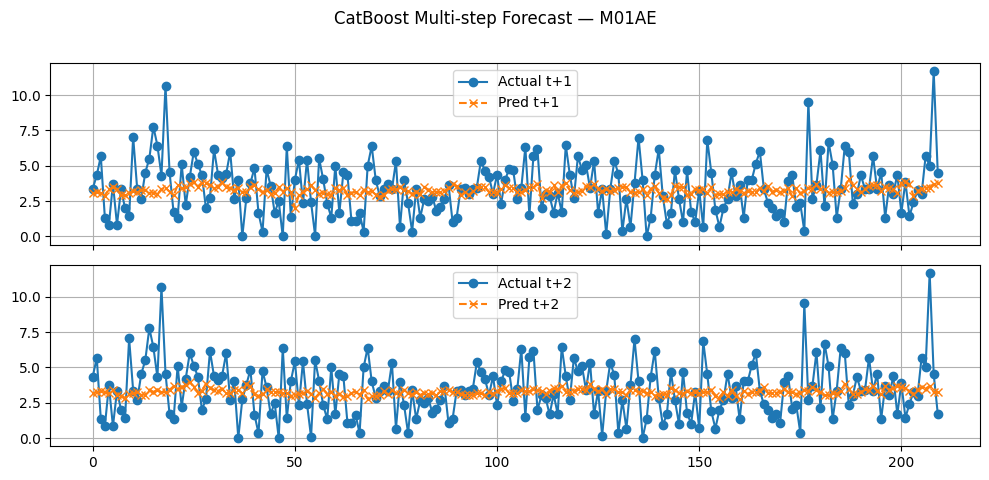

{'drug': 'M01AE', 'MAE': np.float64(0.3705173626643228), 'MSE': np.float64(0.23100363177272357), 'RMSE': 0.4806283717933468, 'MAPE': 29.327789175939365, 'R2': 0.006058100622361007}

===== Processing N02BA =====
0:	learn: 0.7562608	test: 0.8577295	best: 0.8577295 (0)	total: 23.8ms	remaining: 23.7s
100:	learn: 0.6823358	test: 0.8001119	best: 0.8001119 (100)	total: 922ms	remaining: 8.21s
200:	learn: 0.6410160	test: 0.7950903	best: 0.7947681 (196)	total: 2.15s	remaining: 8.56s
300:	learn: 0.6027935	test: 0.7917599	best: 0.7917599 (300)	total: 2.91s	remaining: 6.77s
400:	learn: 0.5644355	test: 0.7908458	best: 0.7900202 (374)	total: 3.68s	remaining: 5.5s
500:	learn: 0.5281816	test: 0.7921367	best: 0.7896135 (433)	total: 4.4s	remaining: 4.38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7896135076
bestIteration = 433

Shrink model to first 434 iterations.

=== N02BA Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,1.5,6.0,3.050554,3.379031
1,6.0,0.2,3.466565,3.152057
2,0.2,3.0,2.664296,2.207714
3,3.0,5.0,2.267468,3.148470
4,5.0,2.0,3.532126,3.191686
5,2.0,2.1,2.944974,2.433859
6,2.1,1.5,2.018072,3.351498
7,1.5,2.0,3.097048,2.933002
8,2.0,0.0,2.618989,1.882294
9,0.0,1.1,2.390235,2.896206


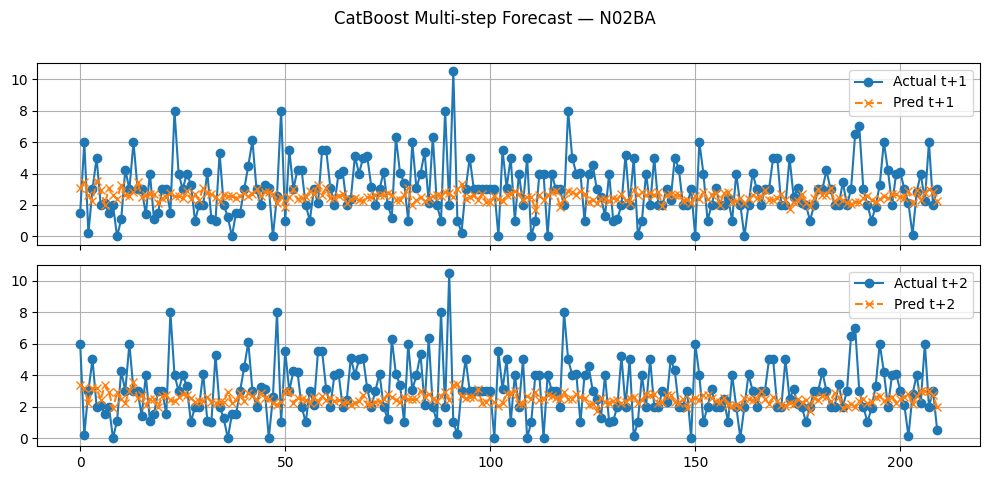

{'drug': 'N02BA', 'MAE': np.float64(0.3842602698072265), 'MSE': np.float64(0.24116866960531982), 'RMSE': 0.4910892684689005, 'MAPE': 29.23325441764065, 'R2': -0.03345660728546895}

===== Processing N02BE =====
0:	learn: 0.8366774	test: 1.0534509	best: 1.0534509 (0)	total: 19.6ms	remaining: 19.6s
100:	learn: 0.6755716	test: 0.9464202	best: 0.9464202 (100)	total: 865ms	remaining: 7.69s
200:	learn: 0.6209868	test: 0.9176106	best: 0.9176106 (200)	total: 1.79s	remaining: 7.11s
300:	learn: 0.5786529	test: 0.9026767	best: 0.9023180 (299)	total: 2.56s	remaining: 5.95s
400:	learn: 0.5403035	test: 0.8921182	best: 0.8921182 (400)	total: 3.3s	remaining: 4.93s
500:	learn: 0.5056998	test: 0.8864813	best: 0.8863965 (499)	total: 4s	remaining: 3.99s
600:	learn: 0.4755169	test: 0.8841815	best: 0.8834738 (583)	total: 4.8s	remaining: 3.18s
700:	learn: 0.4450827	test: 0.8798888	best: 0.8798888 (700)	total: 5.52s	remaining: 2.35s
800:	learn: 0.4177353	test: 0.8768178	best: 0.8768056 (794)	total: 6.21s	remai

,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,31.85,22.0,19.775227,20.261394
1,22.00,47.2,19.952747,28.654604
2,47.20,40.0,27.174757,32.325210
3,40.00,29.0,36.003837,32.902597
4,29.00,55.0,39.213724,29.714899
5,55.00,23.0,30.486933,26.260825
6,23.00,26.2,29.153566,28.971690
7,26.20,28.9,28.864400,25.988497
8,28.90,18.8,30.558132,29.270970
9,18.80,41.0,32.511348,31.286398


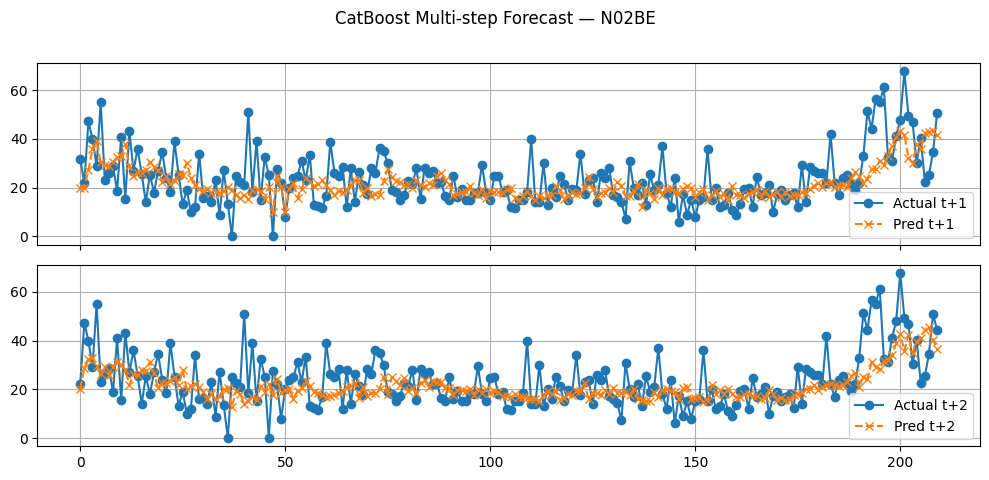

{'drug': 'N02BE', 'MAE': np.float64(0.3194862473584421), 'MSE': np.float64(0.21751167234329433), 'RMSE': 0.4663814665521072, 'MAPE': 12.319223466358084, 'R2': 0.16882513692268053}

===== Processing N05B =====
0:	learn: 0.9221235	test: 0.8063175	best: 0.8063175 (0)	total: 7.86ms	remaining: 7.85s
100:	learn: 0.7914329	test: 0.8130099	best: 0.8058475 (2)	total: 630ms	remaining: 5.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8058475044
bestIteration = 2

Shrink model to first 3 iterations.

=== N05B Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,12.0,10.0,7.260611,7.196618
1,10.0,12.0,7.322896,7.129689
2,12.0,7.0,7.133824,7.187267
3,7.0,9.0,7.218844,7.128407
4,9.0,6.0,7.273893,7.243074
5,6.0,11.0,7.185140,7.194804
6,11.0,10.0,7.167101,7.221041
7,10.0,8.2,7.287651,7.281178
8,8.2,13.0,7.292267,7.248078
9,13.0,13.0,7.241692,7.227270


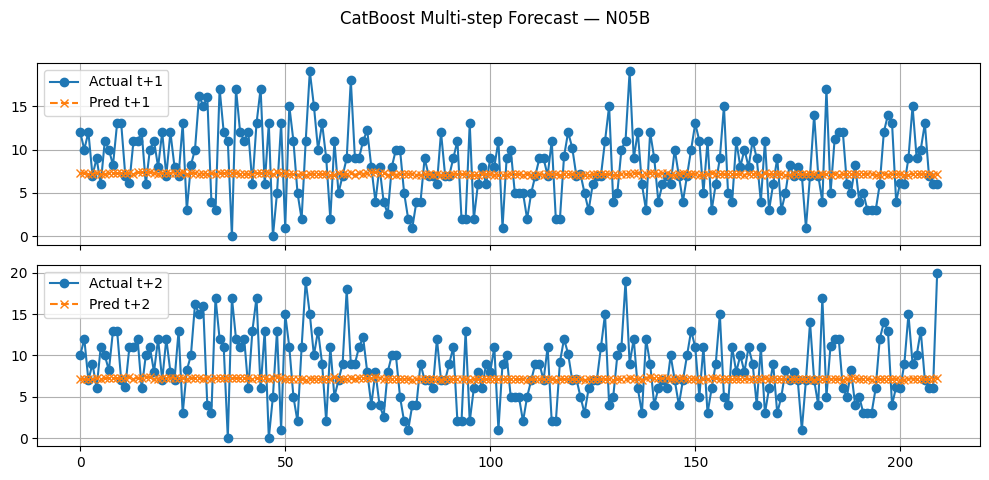

{'drug': 'N05B', 'MAE': np.float64(0.404296572774255), 'MSE': np.float64(0.2761013798784806), 'RMSE': 0.5254534992541972, 'MAPE': 23.37380763272018, 'R2': 0.005613484054491469}

===== Processing N05C =====
0:	learn: 0.6944570	test: 0.7449453	best: 0.7449453 (0)	total: 7.95ms	remaining: 7.95s
100:	learn: 0.6458144	test: 0.7482107	best: 0.7446398 (6)	total: 428ms	remaining: 3.81s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.744639756
bestIteration = 6

Shrink model to first 7 iterations.

=== N05C Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,0.0,0.0,0.343321,0.335889
1,0.0,1.0,0.338120,0.343711
2,1.0,1.0,0.339334,0.340250
3,1.0,0.0,0.346152,0.341650
4,0.0,0.0,0.339706,0.346144
5,0.0,0.0,0.344612,0.343939
6,0.0,1.0,0.335510,0.347860
7,1.0,0.0,0.340464,0.330500
8,0.0,0.0,0.340349,0.332189
9,0.0,0.0,0.346977,0.341107


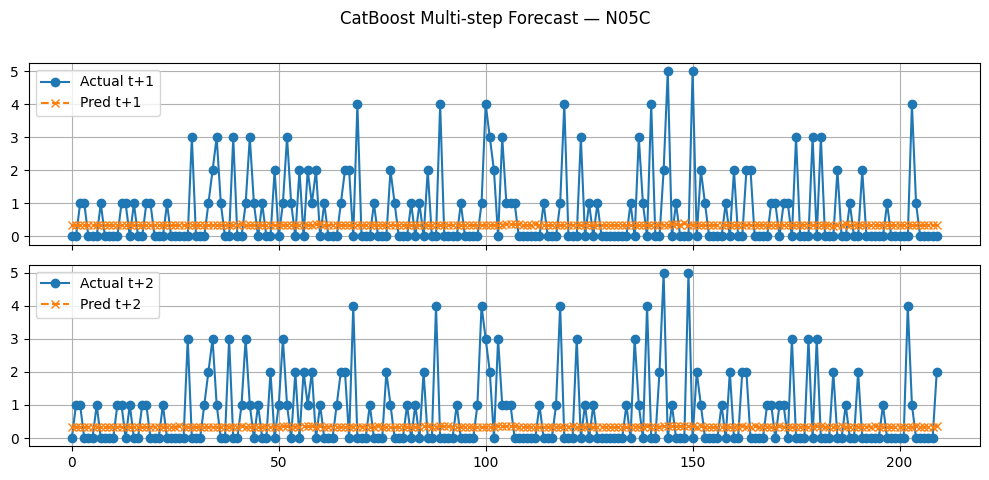

{'drug': 'N05C', 'MAE': np.float64(0.4453637176074388), 'MSE': np.float64(0.27876829707238054), 'RMSE': 0.5279851295939882, 'MAPE': 40.15080043396598, 'R2': -0.0249958012974143}

===== Processing R03 =====
0:	learn: 1.3988293	test: 1.6984819	best: 1.6984819 (0)	total: 9.76ms	remaining: 9.75s
100:	learn: 1.2436632	test: 1.5292027	best: 1.5287665 (99)	total: 729ms	remaining: 6.49s
200:	learn: 1.1649192	test: 1.5078737	best: 1.5078737 (200)	total: 1.29s	remaining: 5.14s
300:	learn: 1.0933996	test: 1.5036602	best: 1.5018881 (296)	total: 1.76s	remaining: 4.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.50188806
bestIteration = 296

Shrink model to first 297 iterations.

=== R03 Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,7.0,8.0,3.854847,3.990055
1,8.0,27.0,4.926566,3.312006
2,27.0,20.0,3.752911,4.202646
3,20.0,5.0,5.684366,4.739299
4,5.0,10.0,4.669205,4.356483
5,10.0,1.0,5.194458,3.730451
6,1.0,2.0,5.604005,5.844005
7,2.0,19.0,4.246472,3.832657
8,19.0,6.0,4.272067,4.727072
9,6.0,29.0,5.098302,4.202068


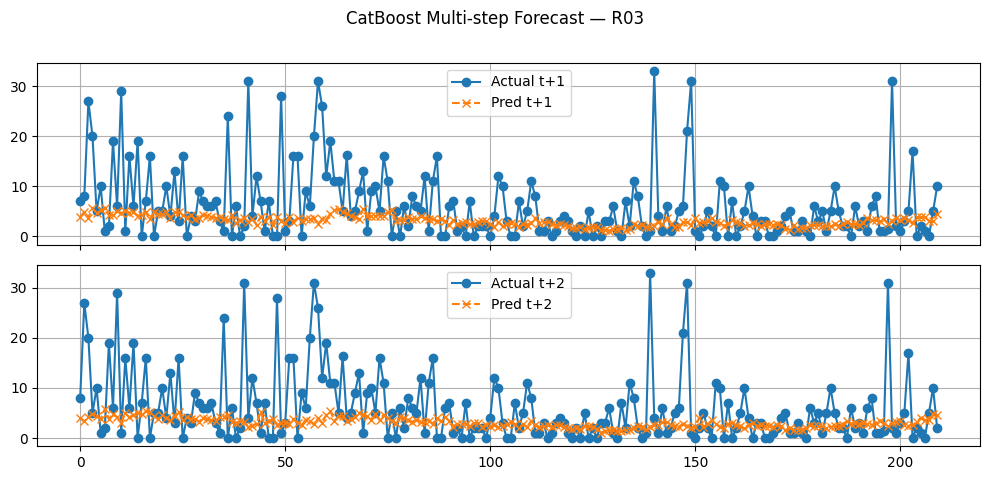

{'drug': 'R03', 'MAE': np.float64(0.7936675448033628), 'MSE': np.float64(0.9144702661625713), 'RMSE': 0.9562793870844291, 'MAPE': 52.24178423850259, 'R2': 0.04248518419993064}

===== Processing R06 =====
0:	learn: 0.8833695	test: 0.8706668	best: 0.8706668 (0)	total: 18.3ms	remaining: 18.3s
100:	learn: 0.7126636	test: 0.8043420	best: 0.8043420 (100)	total: 598ms	remaining: 5.33s
200:	learn: 0.6665717	test: 0.8017968	best: 0.8016449 (142)	total: 1.14s	remaining: 4.55s
300:	learn: 0.6249745	test: 0.8001567	best: 0.7988905 (255)	total: 1.74s	remaining: 4.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7988905124
bestIteration = 255

Shrink model to first 256 iterations.

=== R06 Prediction vs Actual ===


,Actual_t+1,Actual_t+2,Pred_t+1,Pred_t+2
0,2.0,4.0,3.823604,3.427368
1,4.0,6.0,3.594472,3.584522
2,6.0,5.0,3.630514,4.070465
3,5.0,7.0,3.983270,3.838339
4,7.0,5.0,4.100504,4.157100
5,5.0,9.0,4.384537,4.974532
6,9.0,8.0,4.657936,5.092793
7,8.0,5.0,4.754362,4.300075
8,5.0,5.0,4.774621,4.470273
9,5.0,6.0,4.864292,4.714012


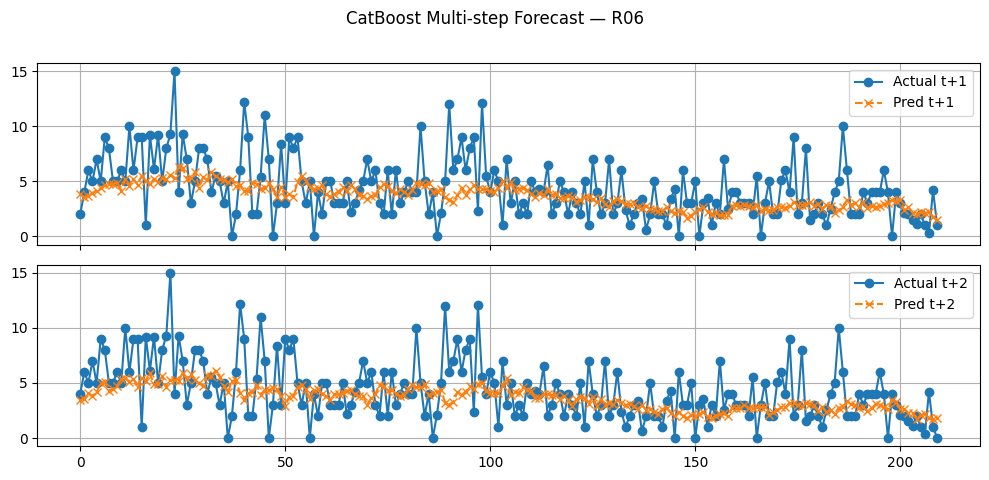

{'drug': 'R06', 'MAE': np.float64(0.4004302285643672), 'MSE': np.float64(0.27091422437539814), 'RMSE': 0.5204942116636824, 'MAPE': 27.96388271714748, 'R2': 0.1319013222144353}

=== Summary Metrics ===


,drug,MAE,MSE,RMSE,MAPE,R2
0,M01AB,0.381778,0.246804,0.496794,24.181040,-0.035008
1,M01AE,0.370517,0.231004,0.480628,29.327789,0.006058
2,N02BA,0.384260,0.241169,0.491089,29.233254,-0.033457
3,N02BE,0.319486,0.217512,0.466381,12.319223,0.168825
4,N05B,0.404297,0.276101,0.525453,23.373808,0.005613
5,N05C,0.445364,0.278768,0.527985,40.150800,-0.024996
6,R03,0.793668,0.914470,0.956279,52.241784,0.042485
7,R06,0.400430,0.270914,0.520494,27.963883,0.131901


In [69]:
# ---------------- MAIN ----------------
if __name__=="__main__":
    df = pd.read_csv(CSV_PATH)
    df = add_calendar_features(df, DATE_COL)
    print("Calendar features added:", ['year','month','day','dayofweek','weekofyear','quarter','is_month_start','is_month_end'])

    results = []
    for drug in DEFAULT_DRUGS:
        if drug not in df.columns:
            print(f"Skipping {drug}, column not found.")
            continue
        print(f"\n===== Processing {drug} =====")
        try:
            res = run_for_drug(df, drug)
        except Exception as e:
            res = {"drug": drug, "error": str(e)}
        results.append(res)
        print(res)

    # display final summary in cell
    print("\n=== Summary Metrics ===")
    display(pd.DataFrame(results))

## Conclusion

This notebook demonstrates a comprehensive approach to drug consumption forecasting using CatBoost. The model incorporates various feature engineering techniques to capture temporal patterns and relationships between different drug categories.


- CatBoost pipeline gives low MAE (≈0.3–0.4) for most drugs.

- Forecast accuracy is drug-dependent (best: N02BE, weaker: R03).

- R² near zero/negative → needs more features & tuning.

- Overall: Predictions are close to actual values, but model can be improved.

Further improvements could include hyperparameter tuning, additional feature engineering, or exploring alternative models for comparison.